In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [2]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):

        txt2 = ax.annotate('\n' + str(int(data[mxy[i], mxx[i]])), xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]),
                           xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), 
                color=color, size=12, clip_on=True, annotation_clip=True, fontweight='normal', 
                           horizontalalignment='center', verticalalignment='top',
                transform=ccrs.PlateCarree())  

In [3]:
date=20231115
time=0
step=36

In [4]:
sfc_parameters = ['10u', '10v']
sfc_filename = 'medium-bulk-shear_sfc.grib2'
sfc_filename

'medium-bulk-shear_sfc.grib2'

In [5]:
pl_parameters = ['u', 'v']
pl_filename = 'medium-bulk-shear_pl.grib'
pl_filename

'medium-bulk-shear_pl.grib'

In [6]:
client = Client()
client.retrieve(
    date=date,
    time=time,
    step=step,
    stream="oper",
    type="fc",
    levtype="sfc",
    param=sfc_parameters,
    target=sfc_filename)

20231115000000-36h-oper-fc.grib2:   0%|          | 0.00/710k [00:00<?, ?B/s]

In [7]:
client = Client()
client.retrieve(
    date=date,
    time=time,
    step=step,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[1000,925,850,700,500,300,250,200,50],
    param=pl_parameters,
    target=pl_filename
)

20231115000000-36h-oper-fc.grib2:   0%|          | 0.00/5.19M [00:00<?, ?B/s]

In [8]:
ds0=xr.open_dataset(sfc_filename, engine="cfgrib")
ds1=xr.open_dataset(pl_filename, engine="cfgrib")

In [9]:
u10=ds0['u10']
v10=ds0['v10']
lon=ds0['longitude']
lat=ds0['latitude']

In [10]:
u500=ds1['u'][4,:,:]
v500=ds1['v'][4,:,:]
lon=ds1['longitude']
lat=ds1['latitude']

In [11]:
#shear_intensity=np.sqrt((u10-u500)*(u10-u500)+(v10-v500)*(v10-v500)) # em m/s
shear_intensity=np.sqrt((u10-u500)*(u10-u500)+(v10-v500)*(v10-v500))*1.94384 # em kt

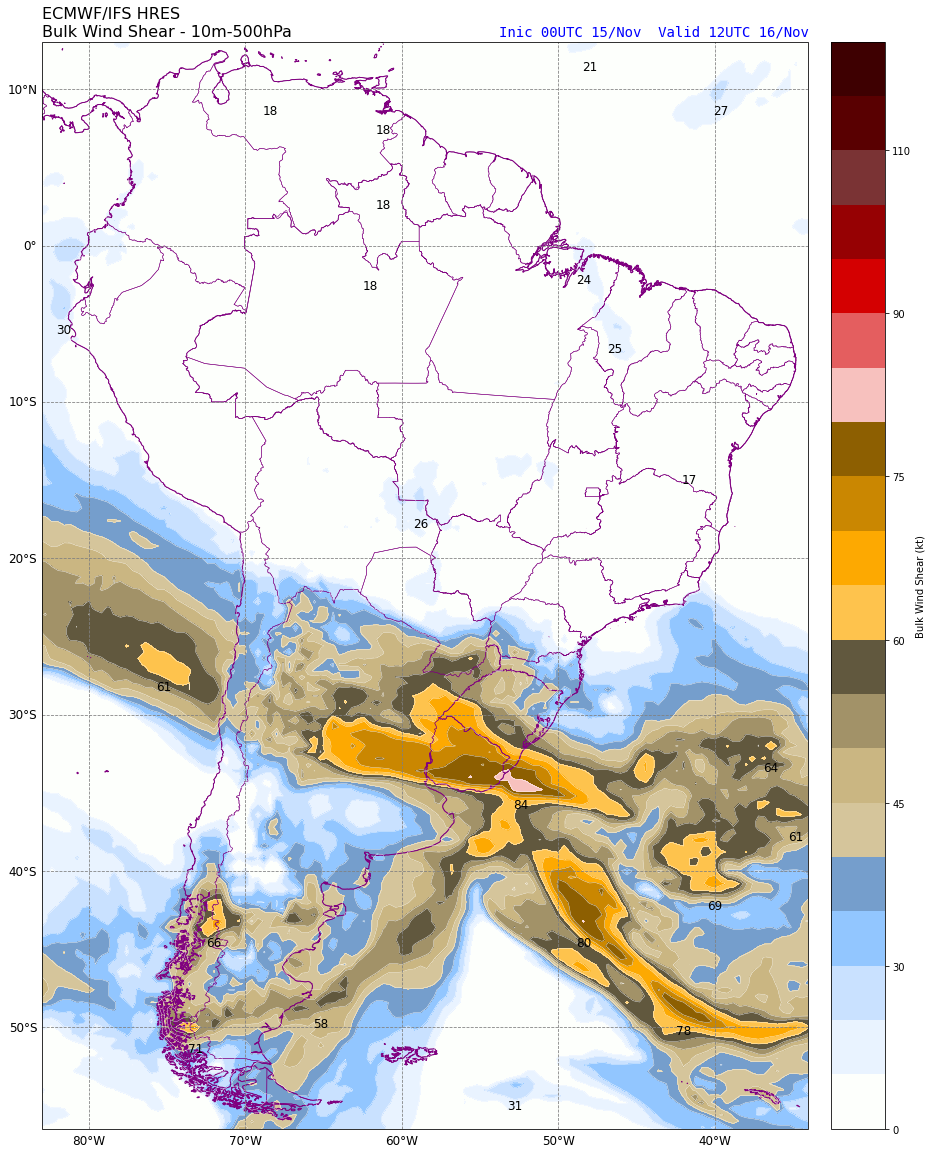

In [17]:
lon,lat=np.meshgrid(shear_intensity.longitude,shear_intensity.latitude)
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m",color='purple')
ax.set_extent([-83,-34,12,-54])
#ax.set_extent([-58,-47,-34,-22])
#cores=['#fdfffc','#c9e1ff','#92c6ff','#cab682','#fda901','#f7c1be','#e45e5f','#d40001','#960103','#590001'] # em m/s
cores=['#fdfffc','#e9f3ff','#c9e1ff','#92c6ff','#759ecc','#d5c59b','#cab682','#a29268','#61583e','#fec34d','#fda901','#ca8701',
       '#8d5f01','#f7c1be','#e45e5f','#d40001','#960103','#7a3334','#590001','#3e0001'] # kt
#levels=[0,20,25,30,35,40,45,50,55,60,70] # em m/s
levels=[0,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130] # em kt

im=ax.contourf(lon,lat,shear_intensity,levels=levels,
               colors=cores,
               transform=ccrs.PlateCarree())
im1=ax.contour(lon,lat,shear_intensity,levels=levels,
               linewidths=0.4,
              colors='white',
              transform=ccrs.PlateCarree())

plot_maxmin_points(lon,lat,shear_intensity,'max',20,symbol='máx',
                   color='k',
                   transform=ccrs.PlateCarree())

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='purple',facecolor='none',linestyle='-',linewidth=.5)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='purple',facecolor='none',linestyle='-',linewidth=.5)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}

#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.044,orientation='horizontal')
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
#cbar.set_label(label='Bulk Wind Shear (m/s)',size=10)
cbar.set_label(label='Bulk Wind Shear (kt)',size=10)
plt.title('ECMWF/IFS HRES\nBulk Wind Shear - 10m-500hPa',fontsize=16,loc='left')
plt.title(ds0.time.dt.strftime('Inic %HUTC %d/%b  ').item()+ds0.valid_time.dt.strftime('Valid %HUTC %d/%b').item(),
          fontsize=14,loc='right',color='blue',fontweight='normal',fontfamily='monospace')
plt.savefig('BWS_10_500_'+ds0.valid_time.dt.strftime('%HUTC_%d_%b').item()+'.jpeg',dpi=300,bbox_inches='tight')

In [13]:
u925=ds1['u'][1,:,:]
v925=ds1['v'][1,:,:]
lon=ds1['longitude']
lat=ds1['latitude']

In [14]:
shear_intensity_10_925=np.sqrt((u10-u925)*(u10-u925)+(v10-v925)*(v10-v925))

In [ ]:
lon,lat=np.meshgrid(shear_intensity_10_925.longitude,shear_intensity_10_925.latitude)
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m",color='purple')
ax.set_extent([-83,-34,12,-54])
#ax.set_extent([-58,-47,-34,-22])
cores=['#fdfffc','#c9e1ff','#92c6ff','#cab682','#fda901','#f7c1be','#e45e5f','#d40001','#960103','#590001']
levels=[0,20,25,30,35,40,45,50,55,60,70]


im=ax.contourf(lon,lat,shear_intensity_10_925,levels=levels,
               colors=cores,
               transform=ccrs.PlateCarree())
im1=ax.contour(lon,lat,shear_intensity_10_925,levels=levels,
               linewidths=0.4,
              colors='white',
              transform=ccrs.PlateCarree())

plot_maxmin_points(lon,lat,shear_intensity_10_925,'max',20,symbol='máx',
                   color='k',
                   transform=ccrs.PlateCarree())

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='purple',facecolor='none',linestyle='-',linewidth=.5)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='purple',facecolor='none',linestyle='-',linewidth=.5)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}

#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.044,orientation='horizontal')
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
cbar.set_label(label='Bulk Wind Shear (m/s)',size=10)
plt.title('ECMWF/IFS HRES\nBulk Wind Shear - 10m-925hPa',fontsize=16,loc='left')
plt.title(ds0.time.dt.strftime('Inic %HUTC %d/%b  ').item()+ds0.valid_time.dt.strftime('Valid %HUTC %d/%b').item(),
          fontsize=14,loc='right',color='blue',fontweight='normal',fontfamily='monospace')
plt.savefig('BWS_10_925_'+ds1.valid_time.dt.strftime('%HUTC_%d_%b').item()+'.jpeg',dpi=300,bbox_inches='tight')